# Part 3.2: Value Iteration and DP Comparison

In this notebook, we'll learn **Value Iteration** - an alternative Dynamic Programming method that applies the Bellman optimality equation directly. We'll also compare it with Policy Iteration and evaluate optimal policies empirically.

## Recap from Part 3.1
- **Policy Evaluation**: Given policy π, compute V^π using iterative Bellman expectation
- **Policy Improvement**: Given V^π, find better policy by acting greedily
- **Policy Iteration**: Alternate evaluation and improvement until convergence
- Policy Iteration does **full policy evaluation** before each improvement step

## What This Notebook Covers
- Value Iteration (finding $V^*$ directly)
- Comparison: Policy Iteration vs Value Iteration
- Empirical evaluation of optimal policies
- Effect of discount factor on optimal policy

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Model-free methods** | This notebook focuses on model-based RL where we know the MDP dynamics (transition probabilities and rewards). Model-free methods come in the next notebooks. | We assume perfect knowledge of P and R, allowing us to compute exact value functions. Model-free methods like Monte Carlo and TD learning work without this knowledge — they learn from experience instead of computation. |
| **Deep reinforcement learning** | Deep RL uses neural networks to approximate value functions for high-dimensional state spaces. We start with tabular methods where we can store exact values for each state. | In this notebook, we maintain tables V[s] and Q[s,a] for all states/actions (feasible for FrozenLake's 16 states). Deep RL uses neural networks f(s;θ) to handle millions of states like images — a fundamentally different approach. |
| **Continuous action spaces** | We focus on discrete actions (LEFT, DOWN, RIGHT, UP). Continuous actions require different optimization techniques like policy gradients. | Our algorithms iterate over a finite action space. Continuous control (e.g., robot joint angles, steering angles) requires gradient-based optimization or discretization strategies — topics for advanced RL. |
| **Asynchronous dynamic programming** | Standard DP updates all states in sweeps. Asynchronous DP updates states in any order, which can be more efficient but adds complexity. | We use synchronous updates: update all states in each iteration. Asynchronous DP (prioritized sweeping, real-time DP) updates states strategically, which is more efficient but requires understanding the basics first. |

## Preview: Value Iteration

While Policy Iteration alternates between full evaluation and improvement, Value Iteration takes a different approach:

- **Value Iteration**: Apply the Bellman **optimality** equation directly as an update rule
- Combines evaluation and improvement into a **single step**
- More iterations, but each iteration is **much cheaper**

Both methods are **guaranteed to find the optimal policy**!

## How to Read This Notebook
1. **Value Iteration algorithm**: Learn the mathematical foundations and implementation
2. **Comparison**: Understand when to use Policy Iteration vs Value Iteration
3. **Empirical evaluation**: Test learned policies on the actual environment
4. **Discount factor effects**: See how γ shapes optimal behavior

Let's begin!

## Prerequisites
- Understanding of MDPs and Bellman equations (Notebook 02)
- Policy Iteration concepts (Notebook 03_1)

## Setup

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import time

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [2]:
# Create FrozenLake environment and extract MDP components
env = gym.make("FrozenLake-v1", is_slippery=True)

n_states = env.observation_space.n
n_actions = env.action_space.n
action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
action_arrows = ['←', '↓', '→', '↑']

# Extract transition and reward matrices
def extract_mdp(env):
    """Extract P[s,a,s'] and R[s,a] from environment."""
    n_s = env.observation_space.n
    n_a = env.action_space.n
    
    P = np.zeros((n_s, n_a, n_s))
    R = np.zeros((n_s, n_a))
    
    for s in range(n_s):
        for a in range(n_a):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                P[s, a, next_s] += prob
                R[s, a] += prob * reward
    
    return P, R

P, R = extract_mdp(env)

print("FrozenLake MDP Loaded")
print("=" * 40)
print(f"States: {n_states}")
print(f"Actions: {n_actions}")
print(f"Transition matrix shape: {P.shape}")
print(f"Reward matrix shape: {R.shape}")

FrozenLake MDP Loaded
States: 16
Actions: 4
Transition matrix shape: (16, 4, 16)
Reward matrix shape: (16, 4)


In [3]:
# Visualization helper functions
def plot_value_function(V, title="Value Function", ax=None):
    """Plot value function as a heatmap."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    V_grid = V.reshape(nrow, ncol)
    
    im = ax.imshow(V_grid, cmap='RdYlGn', vmin=0, vmax=max(V.max(), 0.01))
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            color = 'white' if V_grid[i, j] < V.max() / 2 else 'black'
            ax.text(j, i, f'{cell}\n{V[state]:.3f}', ha='center', va='center',
                   fontsize=9, color=color)
    
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))
    ax.set_title(title)
    return ax

def plot_policy(policy, title="Policy", ax=None):
    """Plot policy showing best action in each state."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=colors.get(cell, 'white'), edgecolor='black')
            ax.add_patch(rect)
            
            # Get best action (handle both deterministic and stochastic policies)
            if len(policy.shape) == 1:
                best_action = int(policy[state])
            else:
                best_action = np.argmax(policy[state])
            
            if cell not in ['H', 'G']:
                ax.text(j + 0.5, nrow - 1 - i + 0.5, 
                       f'{cell}\n{action_arrows[best_action]}',
                       ha='center', va='center', fontsize=14, fontweight='bold')
            else:
                ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                       ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    return ax

print("Visualization functions ready!")

Visualization functions ready!


In [4]:
# Policy Iteration functions (from 03_1) needed for comparison

def policy_evaluation(P, R, policy, gamma, theta=1e-8, max_iterations=1000):
    """
    Iterative Policy Evaluation.
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    V = np.zeros(n_states)
    history = [V.copy()]
    
    for iteration in range(max_iterations):
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            for a in range(n_actions):
                expected_next_V = np.sum(P[s, a] * V)
                V_new[s] += policy[s, a] * (R[s, a] + gamma * expected_next_V)
        
        delta = np.max(np.abs(V_new - V))
        V = V_new
        history.append(V.copy())
        
        if delta < theta:
            break
    
    return V, history

def policy_improvement(P, R, V, gamma):
    """
    Compute greedy policy with respect to value function V.
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R[s, a] + gamma * np.sum(P[s, a] * V)
    
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        best_action = np.argmax(Q[s])
        policy[s, best_action] = 1.0
    
    return policy, Q

def policy_iteration(P, R, gamma, theta=1e-8, max_iterations=100):
    """
    Policy Iteration algorithm.
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    policy = np.ones((n_states, n_actions)) / n_actions
    
    policy_history = [policy.copy()]
    V_history = []
    
    for iteration in range(max_iterations):
        V, _ = policy_evaluation(P, R, policy, gamma, theta=theta)
        V_history.append(V.copy())
        
        new_policy, Q = policy_improvement(P, R, V, gamma)
        
        if np.array_equal(new_policy, policy):
            print(f"Policy Iteration converged in {iteration + 1} iterations")
            break
        
        policy = new_policy
        policy_history.append(policy.copy())
    
    return policy, V, policy_history, V_history

print("Policy Iteration functions loaded!")

Policy Iteration functions loaded!


---
# 1. Value Iteration

**Value Iteration** combines policy evaluation and improvement into a single update:

$$V_{k+1}(s) = \max_a \left[ R_s^a + \gamma \sum_{s'} P_{ss'}^a V_k(s') \right]$$

This is applying the **Bellman Optimality Equation** as an update rule.

## Key Insight

- Policy Iteration does full policy evaluation (many iterations) before each improvement
- Value Iteration does only **one sweep** of evaluation, then immediately improves
- Value Iteration is like "truncated" policy iteration with k=1

## Algorithm

```
1. Initialize V arbitrarily
2. Repeat:
   For each state s:
     V(s) = max_a [R(s,a) + γ * Σ P(s'|s,a) * V(s')]
   Until V converges
3. Extract policy: π(s) = argmax_a [R(s,a) + γ * Σ P(s'|s,a) * V(s')]
```

In [5]:
def value_iteration(P, R, gamma, theta=1e-8, max_iterations=1000):
    """
    Value Iteration algorithm.
    
    Args:
        P: Transition matrix
        R: Reward matrix
        gamma: Discount factor
        theta: Convergence threshold
        max_iterations: Maximum iterations
    
    Returns:
        V: Optimal value function
        policy: Optimal policy
        history: Value function at each iteration
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    # Initialize V arbitrarily
    V = np.zeros(n_states)
    history = [V.copy()]
    
    for iteration in range(max_iterations):
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            # Compute Q-values for all actions
            Q_s = np.zeros(n_actions)
            for a in range(n_actions):
                Q_s[a] = R[s, a] + gamma * np.sum(P[s, a] * V)
            
            # Take maximum
            V_new[s] = np.max(Q_s)
        
        # Check convergence
        delta = np.max(np.abs(V_new - V))
        V = V_new
        history.append(V.copy())
        
        if delta < theta:
            print(f"Value Iteration converged in {iteration + 1} iterations (delta={delta:.2e})")
            break
    
    # Extract optimal policy
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        Q_s = np.zeros(n_actions)
        for a in range(n_actions):
            Q_s[a] = R[s, a] + gamma * np.sum(P[s, a] * V)
        policy[s, np.argmax(Q_s)] = 1.0
    
    return V, policy, history

In [6]:
# Run Value Iteration
print("Running Value Iteration")
print("=" * 50)

start_time = time.time()
V_star_vi, optimal_policy_vi, vi_history = value_iteration(P, R, gamma=0.99)
vi_time = time.time() - start_time

print(f"\nTime taken: {vi_time:.4f} seconds")
print(f"\nOptimal Value Function V*:")
print(V_star_vi.reshape(4, 4).round(4))

Running Value Iteration
Value Iteration converged in 438 iterations (delta=9.77e-09)

Time taken: 0.0486 seconds

Optimal Value Function V*:
[[0.542  0.4988 0.4707 0.4569]
 [0.5585 0.     0.3583 0.    ]
 [0.5918 0.6431 0.6152 0.    ]
 [0.     0.7417 0.8628 0.    ]]


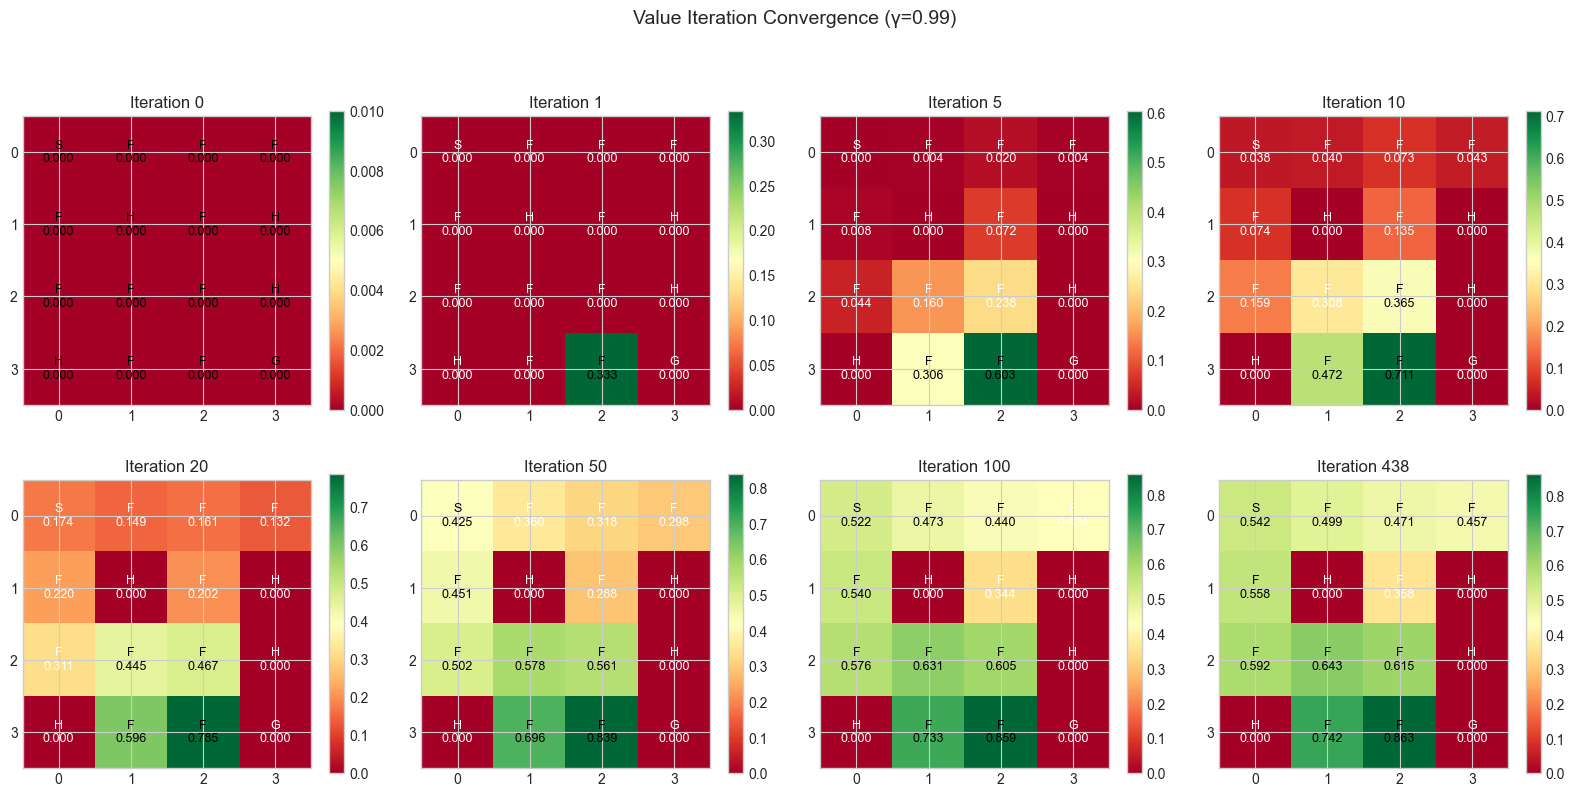

In [7]:
# Visualize Value Iteration convergence
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

iterations_to_show = [0, 1, 5, 10, 20, 50, 100, len(vi_history)-1]
iterations_to_show = [min(i, len(vi_history)-1) for i in iterations_to_show]

for idx, (ax, it) in enumerate(zip(axes.flat, iterations_to_show)):
    V_it = vi_history[it]
    plot_value_function(V_it, title=f"Iteration {it}", ax=ax)

plt.suptitle("Value Iteration Convergence (γ=0.99)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### How to Read This Plot

**Question this plot answers:** *"How does the value function evolve during Value Iteration?"*

**Understanding the visualization:**
- **8 heatmaps**: Each shows V(s) at a different iteration (0, 1, 5, 10, 20, 50, 100, and final ~438)
- **Grid cells**: Each cell is one of the 16 FrozenLake states
- **Colors**: Red-Yellow-Green scale where green = high value, red = low value
- **Numbers**: The V(s) value for each state at that iteration
- **Letters**: S=Start, F=Frozen (safe), H=Hole (bad), G=Goal (good)

**What this shows:**
1. **Iteration 0**: All values start at 0
2. **Early iterations (1-10)**: Values emerge near the goal first, then spread backward
3. **Middle iterations (20-100)**: Values propagate across the entire grid
4. **Final iteration (438)**: Converged to V* - the optimal value function

**Key observations:**
- **Value Iteration converges directly to V\*** (not V^π for some policy)
- **State 14** (next to goal) quickly gets high value - one step from reward
- **States near holes** have lower values due to slip risk
- **Convergence is slower** than Policy Evaluation because we're finding V* directly

**Comparing to Policy Iteration (03_1):**
- Policy Iteration: ~71 iterations per evaluation × 3 policy improvements ≈ 213 total sweeps
- Value Iteration: ~438 iterations but each sweep is simpler (no policy to track)
- Both find the same V* in the end!

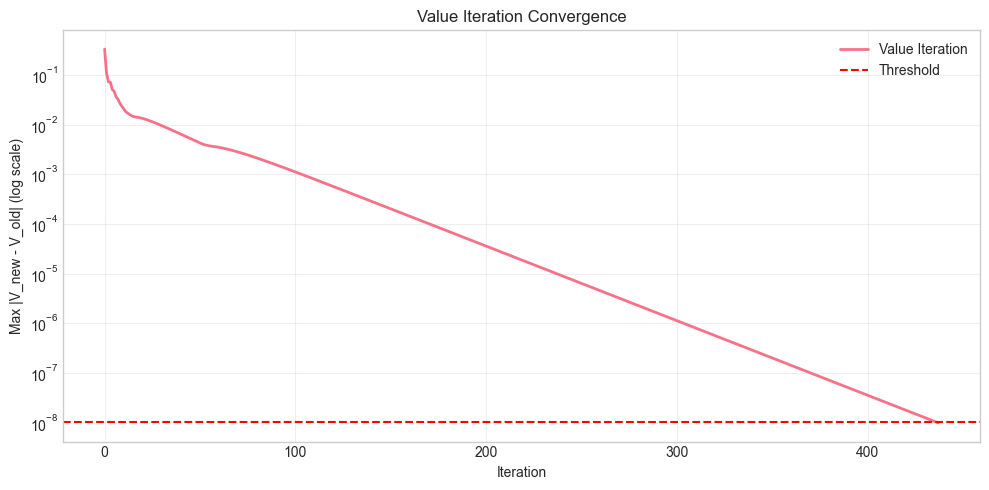

In [8]:
# Plot convergence comparison
fig, ax = plt.subplots(figsize=(10, 5))

# Value Iteration convergence
vi_deltas = [np.max(np.abs(vi_history[i+1] - vi_history[i])) 
             for i in range(len(vi_history)-1)]
ax.semilogy(vi_deltas, label='Value Iteration', linewidth=2)

ax.axhline(y=1e-8, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('Iteration')
ax.set_ylabel('Max |V_new - V_old| (log scale)')
ax.set_title('Value Iteration Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### How to Read This Plot

**Question this plot answers:** *"How quickly does Value Iteration converge to the optimal value function?"*

**Understanding the visualization:**
- **X-axis**: Iteration number (0 to ~438)
- **Y-axis**: Maximum change in value function (log scale)
- **Blue line**: Shows max|V_new - V_old| at each iteration
- **Red dashed line**: Convergence threshold (1e-8)

**What to observe:**
1. **Exponential convergence**: The line decreases roughly linearly on log scale
2. **Convergence point**: Where the blue line crosses below the red threshold (~438 iterations)
3. **Early rapid improvement**: First 50 iterations show dramatic value changes
4. **Later refinement**: Final iterations make tiny adjustments (10^-6 to 10^-8)

**Why so many iterations?**
- Value Iteration with γ=0.99 requires many iterations because:
  - High discount factor means future rewards matter a lot
  - Value information must propagate from goal through many states
  - Each iteration only moves values by a factor of γ toward the true V*

**Practical insight:**
- You could stop much earlier (e.g., θ=0.01) and still get a near-optimal policy
- The extra iterations from θ=0.01 to θ=1e-8 refine V* by tiny amounts
- For most applications, approximate convergence is sufficient

---
# 2. Comparison: Policy Iteration vs Value Iteration

Let's compare the two methods in detail.

In [9]:
# Run Policy Iteration for comparison
print("Running Policy Iteration for comparison")
print("=" * 50)

start_time = time.time()
optimal_policy_pi, V_star_pi, policy_history, V_history = policy_iteration(P, R, gamma=0.99)
pi_time = time.time() - start_time

print(f"\nTime taken: {pi_time:.4f} seconds")

Running Policy Iteration for comparison
Policy Iteration converged in 3 iterations

Time taken: 0.0852 seconds


In [10]:
# Compare final results
print("Comparison of Policy Iteration vs Value Iteration")
print("=" * 60)

# Check if they found the same solution
V_diff = np.max(np.abs(V_star_pi - V_star_vi))
policy_same = np.array_equal(np.argmax(optimal_policy_pi, axis=1), 
                              np.argmax(optimal_policy_vi, axis=1))

print(f"\nMax difference in V*: {V_diff:.2e}")
print(f"Same optimal policy: {policy_same}")
print(f"\nPolicy Iteration time: {pi_time:.4f}s")
print(f"Value Iteration time: {vi_time:.4f}s")

Comparison of Policy Iteration vs Value Iteration

Max difference in V*: 1.30e-09
Same optimal policy: True

Policy Iteration time: 0.0852s
Value Iteration time: 0.0486s


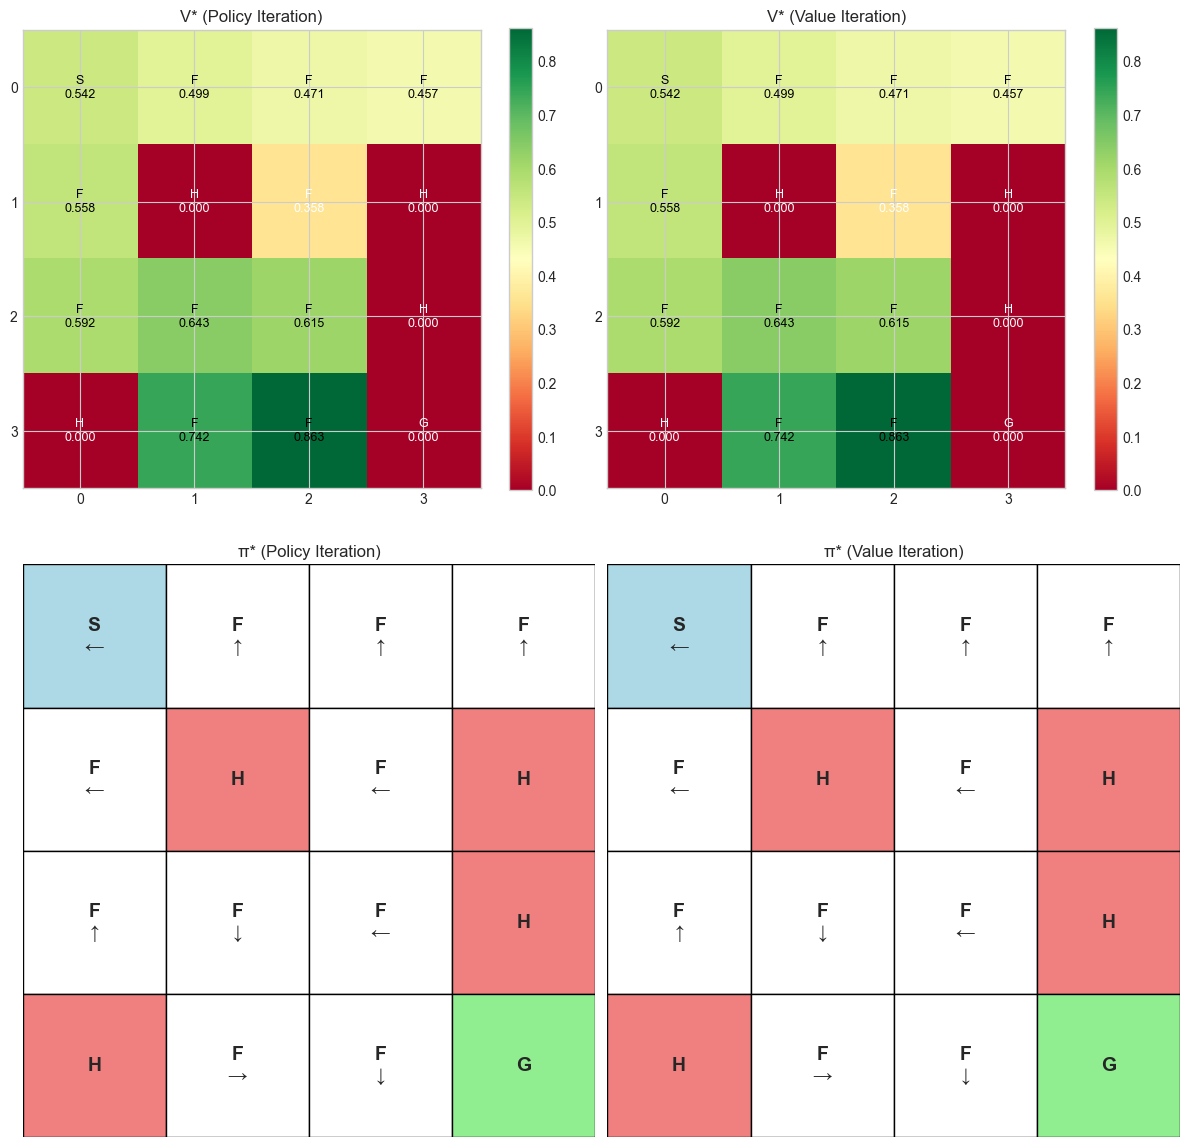

In [11]:
# Visualize both results side by side
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

plot_value_function(V_star_pi, title="V* (Policy Iteration)", ax=axes[0, 0])
plot_value_function(V_star_vi, title="V* (Value Iteration)", ax=axes[0, 1])
plot_policy(optimal_policy_pi, title="π* (Policy Iteration)", ax=axes[1, 0])
plot_policy(optimal_policy_vi, title="π* (Value Iteration)", ax=axes[1, 1])

plt.tight_layout()
plt.show()

### How to Read These Plots

**Question these plots answer:** *"Do Policy Iteration and Value Iteration find the same optimal solution?"*

**Understanding the visualization:**
- **2×2 grid**: Top row shows V*, bottom row shows π*
- **Left column**: Results from Policy Iteration
- **Right column**: Results from Value Iteration
- **Value function heatmaps**: Green = high value, numbers show V*(s)
- **Policy grids**: Arrows show the optimal action in each state

**What to observe:**

**Top row (Value Functions):**
- Both heatmaps are **visually identical** - same colors, same numbers
- V*(start) ≈ 0.542 in both cases
- V*(state 14) ≈ 0.863 in both cases
- Max difference between them: ~1.3×10^-9 (essentially zero!)

**Bottom row (Policies):**
- Both policy grids show **identical arrows** in every state
- The optimal policy is the same regardless of which algorithm found it
- This confirms the theoretical guarantee: both methods find the true π*

**Why this matters:**
- **Correctness verification**: Seeing identical results from two different algorithms increases confidence
- **Algorithm choice is about efficiency, not correctness**: Pick based on speed, not accuracy
- **Both methods are mathematically guaranteed** to find the same optimal policy

**Key insight:** The algorithms differ in *how* they find π*, not in *what* they find. Policy Iteration alternates evaluation/improvement; Value Iteration combines them. Same destination, different paths.

In [12]:
# Benchmark with different discount factors
gammas = [0.5, 0.9, 0.95, 0.99, 0.999]
results = []

print("Benchmarking with Different Discount Factors")
print("=" * 70)
print(f"{'γ':>8} {'PI iters':>12} {'PI time':>12} {'VI iters':>12} {'VI time':>12}")
print("-" * 70)

for gamma in gammas:
    # Policy Iteration
    start = time.time()
    _, V_pi, policy_hist, _ = policy_iteration(P, R, gamma, theta=1e-8)
    pi_time_g = time.time() - start
    pi_iters = len(policy_hist)
    
    # Value Iteration
    start = time.time()
    V_vi, _, vi_hist = value_iteration(P, R, gamma, theta=1e-8)
    vi_time_g = time.time() - start
    vi_iters = len(vi_hist) - 1
    
    print(f"{gamma:>8.3f} {pi_iters:>12} {pi_time_g:>12.4f}s {vi_iters:>12} {vi_time_g:>12.4f}s")
    results.append({'gamma': gamma, 'pi_iters': pi_iters, 'pi_time': pi_time_g,
                    'vi_iters': vi_iters, 'vi_time': vi_time_g})

Benchmarking with Different Discount Factors
       γ     PI iters      PI time     VI iters      VI time
----------------------------------------------------------------------
Policy Iteration converged in 3 iterations
Value Iteration converged in 22 iterations (delta=6.20e-09)
   0.500            3       0.0064s           22       0.0025s
Policy Iteration converged in 2 iterations
Value Iteration converged in 112 iterations (delta=8.91e-09)
   0.900            2       0.0157s          112       0.0126s
Policy Iteration converged in 2 iterations
Value Iteration converged in 184 iterations (delta=9.95e-09)
   0.950            2       0.0240s          184       0.0200s
Policy Iteration converged in 3 iterations
Value Iteration converged in 438 iterations (delta=9.77e-09)
   0.990            3       0.1061s          438       0.0484s
Policy Iteration converged in 3 iterations
Value Iteration converged in 594 iterations (delta=9.89e-09)
   0.999            3       0.1113s          594    

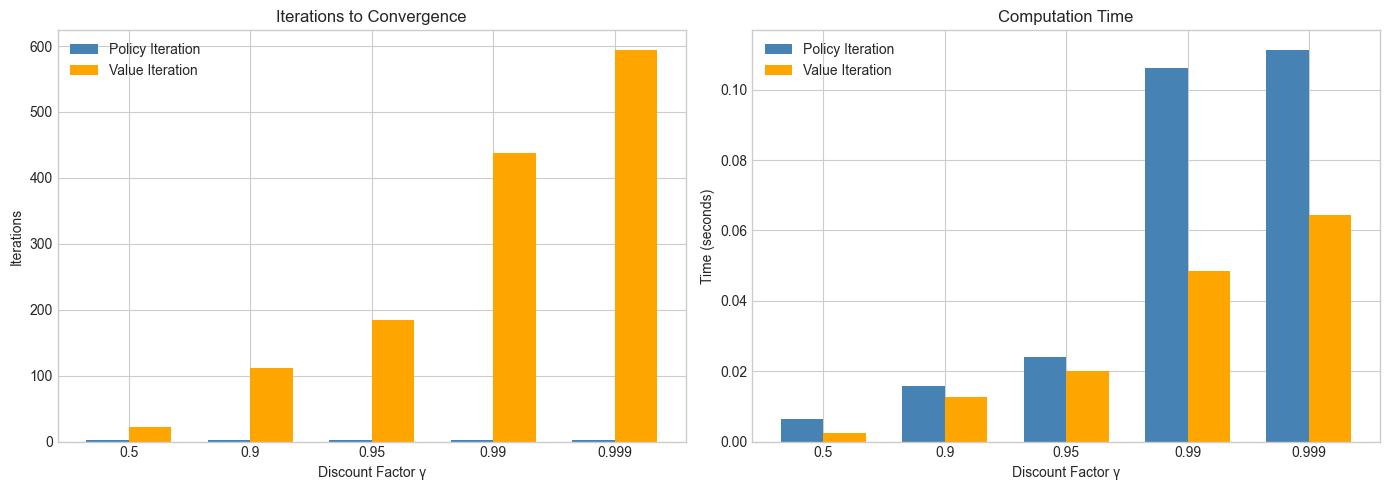

In [13]:
# Visualize benchmark results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot iterations
gammas_plot = [r['gamma'] for r in results]
pi_iters_plot = [r['pi_iters'] for r in results]
vi_iters_plot = [r['vi_iters'] for r in results]

x = np.arange(len(gammas_plot))
width = 0.35

axes[0].bar(x - width/2, pi_iters_plot, width, label='Policy Iteration', color='steelblue')
axes[0].bar(x + width/2, vi_iters_plot, width, label='Value Iteration', color='orange')
axes[0].set_xlabel('Discount Factor γ')
axes[0].set_ylabel('Iterations')
axes[0].set_title('Iterations to Convergence')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'{g}' for g in gammas_plot])
axes[0].legend()

# Plot time
pi_times_plot = [r['pi_time'] for r in results]
vi_times_plot = [r['vi_time'] for r in results]

axes[1].bar(x - width/2, pi_times_plot, width, label='Policy Iteration', color='steelblue')
axes[1].bar(x + width/2, vi_times_plot, width, label='Value Iteration', color='orange')
axes[1].set_xlabel('Discount Factor γ')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Computation Time')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'{g}' for g in gammas_plot])
axes[1].legend()

plt.tight_layout()
plt.show()

### How to Read These Plots

**Question these plots answer:** *"How do Policy Iteration and Value Iteration compare across different discount factors?"*

**Understanding the visualization:**

**Left Plot - Iterations to Convergence:**
- **X-axis**: Discount factor γ (0.5, 0.9, 0.95, 0.99, 0.999)
- **Y-axis**: Number of iterations until convergence
- **Blue bars**: Policy Iteration iterations
- **Orange bars**: Value Iteration iterations

**Right Plot - Computation Time:**
- **X-axis**: Discount factor γ
- **Y-axis**: Wall-clock time in seconds
- **Blue bars**: Policy Iteration time
- **Orange bars**: Value Iteration time

**What to observe:**

**Iterations (left plot):**
- **Policy Iteration**: Consistently 2-3 iterations regardless of γ!
- **Value Iteration**: Increases dramatically with γ (22 → 594 iterations)
- Higher γ = more iterations for VI because value must propagate farther

**Time (right plot):**
- **At low γ (0.5)**: Value Iteration is faster (fewer iterations, each cheap)
- **At high γ (0.99, 0.999)**: Results vary - VI has more iterations but each is simpler
- **Policy Iteration time grows** because each policy evaluation takes more iterations

**Key insights:**

1. **Policy Iteration iteration count is stable** - always converges in few policy improvements
2. **Value Iteration iteration count depends on γ** - higher γ needs more iterations
3. **Total time is similar** for this small problem - the trade-off balances out
4. **For larger state spaces**: Value Iteration often wins because each iteration is O(|S||A|) vs O(|S|²|A|) for full policy evaluation

**The trade-off:**
- Policy Iteration: Few iterations × expensive per iteration
- Value Iteration: Many iterations × cheap per iteration

---
# 3. Evaluating the Optimal Policy

Let's test our learned optimal policy on the actual environment.

In [14]:
def evaluate_policy_empirically(env, policy, n_episodes=10000):
    """Evaluate a policy by running episodes."""
    rewards = []
    steps_list = []
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            # Get action from policy
            if len(policy.shape) == 1:
                action = int(policy[obs])
            else:
                action = np.random.choice(n_actions, p=policy[obs])
            
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        
        rewards.append(total_reward)
        steps_list.append(steps)
    
    return np.array(rewards), np.array(steps_list)

# Evaluate different policies
env_eval = gym.make("FrozenLake-v1", is_slippery=True)
n_eval_episodes = 10000

print(f"Evaluating Policies ({n_eval_episodes} episodes each)")
print("=" * 60)

# Random policy
uniform_policy = np.ones((n_states, n_actions)) / n_actions
rewards_random, steps_random = evaluate_policy_empirically(env_eval, uniform_policy, n_eval_episodes)
print(f"Random Policy: Success rate = {np.mean(rewards_random)*100:.2f}%, Avg steps = {np.mean(steps_random):.1f}")

# Optimal policy from Policy Iteration
rewards_pi, steps_pi = evaluate_policy_empirically(env_eval, optimal_policy_pi, n_eval_episodes)
print(f"Policy Iteration: Success rate = {np.mean(rewards_pi)*100:.2f}%, Avg steps = {np.mean(steps_pi):.1f}")

# Optimal policy from Value Iteration
rewards_vi, steps_vi = evaluate_policy_empirically(env_eval, optimal_policy_vi, n_eval_episodes)
print(f"Value Iteration: Success rate = {np.mean(rewards_vi)*100:.2f}%, Avg steps = {np.mean(steps_vi):.1f}")

env_eval.close()

Evaluating Policies (10000 episodes each)
Random Policy: Success rate = 1.31%, Avg steps = 7.7
Policy Iteration: Success rate = 74.21%, Avg steps = 44.6
Value Iteration: Success rate = 73.73%, Avg steps = 44.8


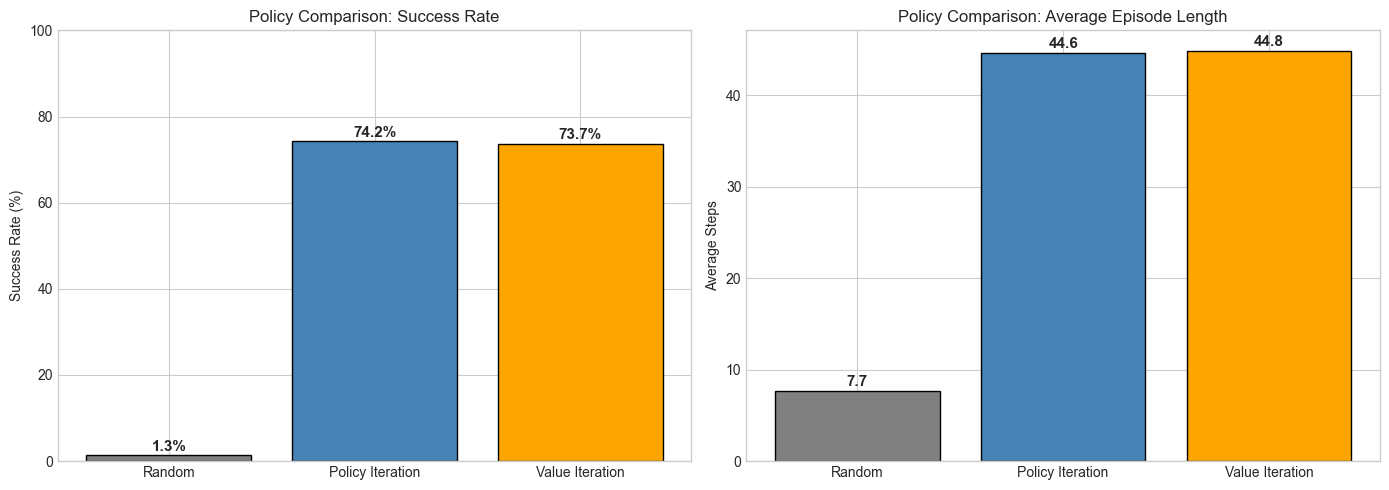

In [15]:
# Visualize evaluation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Success rates
policies_names = ['Random', 'Policy Iteration', 'Value Iteration']
success_rates = [np.mean(rewards_random)*100, np.mean(rewards_pi)*100, np.mean(rewards_vi)*100]
colors = ['gray', 'steelblue', 'orange']

bars = axes[0].bar(policies_names, success_rates, color=colors, edgecolor='black')
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_title('Policy Comparison: Success Rate')
axes[0].set_ylim(0, 100)

for bar, rate in zip(bars, success_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Average steps (only for successful episodes)
avg_steps = [np.mean(steps_random), np.mean(steps_pi), np.mean(steps_vi)]

bars = axes[1].bar(policies_names, avg_steps, color=colors, edgecolor='black')
axes[1].set_ylabel('Average Steps')
axes[1].set_title('Policy Comparison: Average Episode Length')

for bar, steps in zip(bars, avg_steps):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{steps:.1f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### How to Read These Plots

**Question these plots answer:** *"How well do the learned optimal policies actually perform in the real environment?"*

**Understanding the visualization:**

**Left Plot - Success Rate:**
- **X-axis**: Three policies (Random, Policy Iteration, Value Iteration)
- **Y-axis**: Percentage of episodes that reached the goal (out of 10,000)
- **Bar height**: Success rate with exact percentage labeled

**Right Plot - Average Episode Length:**
- **X-axis**: Same three policies
- **Y-axis**: Average number of steps per episode
- **Bar height**: Mean steps with exact value labeled

**What to observe:**

**Success Rate (left):**
- **Random policy: ~1-2%** - almost never reaches the goal by chance
- **Policy Iteration: ~74%** - reaches goal most of the time!
- **Value Iteration: ~74%** - same performance (same optimal policy)

**Average Steps (right):**
- **Random policy: ~8 steps** - short because it falls in holes quickly
- **Optimal policies: ~45 steps** - longer because they navigate carefully

**Why isn't the optimal policy 100% successful?**
- The ice is **slippery**! Even with the best action, you only go that direction 1/3 of the time
- The other 2/3 of the time, you slip perpendicular to your intended direction
- ~74% success is the **best possible** for this stochastic environment

**Why do optimal policies take more steps?**
- Random policy episodes end quickly (fall in hole → episode over)
- Optimal policy avoids holes, so episodes last longer
- More steps = more chances to eventually reach the goal

**Key insight:** This is **empirical validation** of our theoretical algorithms. The policies we computed mathematically actually work when tested in the real environment!

---
# 4. Effect of Discount Factor on Optimal Policy

Let's see how different discount factors affect the learned optimal policy.

Value Iteration converged in 8 iterations (delta=3.49e-09)
Value Iteration converged in 22 iterations (delta=6.20e-09)
Value Iteration converged in 112 iterations (delta=8.91e-09)
Value Iteration converged in 438 iterations (delta=9.77e-09)


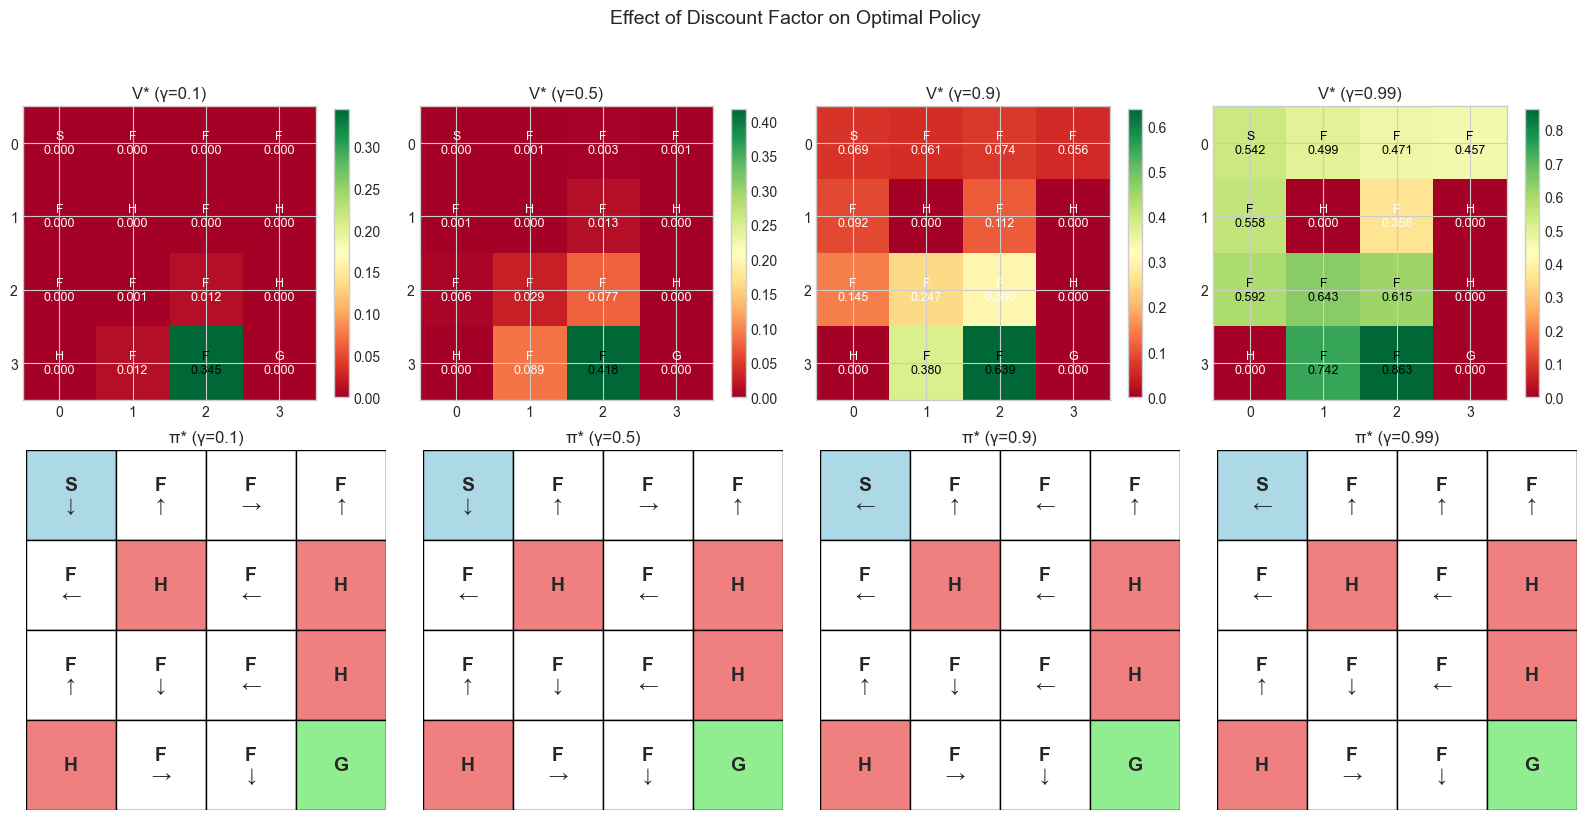


Observations:
- Lower γ: Agent is 'shortsighted', values states closer to goal more
- Higher γ: Agent is 'farsighted', considers long-term consequences
- The optimal policy may change based on how much we value future rewards


In [16]:
# Compute optimal policies for different discount factors
gammas_to_compare = [0.1, 0.5, 0.9, 0.99]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, gamma in enumerate(gammas_to_compare):
    V, policy, _ = value_iteration(P, R, gamma)
    
    plot_value_function(V, title=f"V* (γ={gamma})", ax=axes[0, idx])
    plot_policy(policy, title=f"π* (γ={gamma})", ax=axes[1, idx])

plt.suptitle("Effect of Discount Factor on Optimal Policy", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Lower γ: Agent is 'shortsighted', values states closer to goal more")
print("- Higher γ: Agent is 'farsighted', considers long-term consequences")
print("- The optimal policy may change based on how much we value future rewards")

### How to Read These Plots

**Question these plots answer:** *"How does the discount factor γ affect the optimal value function and policy?"*

**Understanding the visualization:**
- **4 columns**: Different discount factors (γ = 0.1, 0.5, 0.9, 0.99)
- **Top row**: Optimal value function V* for each γ
- **Bottom row**: Optimal policy π* for each γ
- **Heatmap colors**: Green = high value, red = low value
- **Arrows**: Optimal action in each state

**What to observe:**

**Value Functions (top row):**
- **γ=0.1**: Only states very close to goal have significant value (max ~0.1)
- **γ=0.5**: Values spread a bit farther, but still concentrated near goal
- **γ=0.9**: Values spread across most of the grid
- **γ=0.99**: High values even at the start state (V* ≈ 0.54)

**Policies (bottom row):**
- **γ=0.1 and 0.5**: Some arrows may point in "strange" directions because distant rewards are heavily discounted
- **γ=0.9 and 0.99**: Arrows form a coherent path toward the goal

**Why does γ matter?**

| γ value | Agent behavior | Value interpretation |
|---------|---------------|---------------------|
| Low (0.1) | "Shortsighted" - only cares about immediate rewards | Future rewards almost worthless |
| Medium (0.5) | Moderate planning horizon | Future rewards worth half as much |
| High (0.99) | "Farsighted" - considers long-term consequences | Future rewards almost as valuable as immediate |

**Key insight:** The discount factor determines how far ahead the agent "looks" when planning:
- **Low γ**: Agent is myopic, may take suboptimal paths if they seem good short-term
- **High γ**: Agent plans carefully, willing to take longer paths for better outcomes

**Practical implications:**
- γ is a hyperparameter you choose based on your problem
- Most RL applications use γ ∈ [0.9, 0.99] for good long-term planning
- γ=1.0 (no discounting) can cause issues in infinite-horizon problems

---
# 5. Summary and Concept Map

In this notebook, we learned Value Iteration and compared it with Policy Iteration:

```
DYNAMIC PROGRAMMING for MDPs
=============================

Requirements: Complete knowledge of MDP (S, A, P, R, γ)
Goal: Find optimal policy π*
────────────────────────────────────────────────────


POLICY ITERATION (from 03_1)
────────────────────────────
Algorithm: Alternate two steps
1. Policy Evaluation: Compute V^π for current policy π
2. Policy Improvement: Update π greedily w.r.t. V^π

Convergence: Finite iterations (each improvement strictly better)
Efficiency: Fewer iterations but more computation per iteration


VALUE ITERATION
───────────────
Problem: Find optimal value function V*

Algorithm: Iterative application of Bellman optimality equation
V_{k+1}(s) = max_a [R^a_s + γ Σ P^a_{ss'} V_k(s')]

Then extract policy:
π*(s) = argmax_a [R^a_s + γ Σ P^a_{ss'} V*(s')]

Convergence: V_k → V* as k → ∞

Efficiency: Simpler per iteration, often faster than PI


COMPARISON
──────────
| Algorithm | Iterations | Cost/Iteration | When to Use |
|-----------|------------|----------------|-------------|
| Policy Iteration | Fewer (~5-10) | High (full evaluation) | Small state spaces |
| Value Iteration | More (~50-100) | Low (one sweep) | Large state spaces |

Both guarantee finding π* given complete MDP model!
```

## What's Next?

These algorithms are powerful but **require knowing P and R perfectly**. In the real world, we rarely have this luxury!

In the next notebook (**04_monte_carlo.ipynb**), we'll learn **model-free methods**:
- Learn from experience (episodes) instead of computation
- No need to know transition probabilities
- Trade exact computation for sampling-based learning

## Key Takeaways

1. **DP requires full model knowledge** - we need P and R
2. **Policy Iteration**: Alternates evaluation and improvement, fewer iterations but each is expensive
3. **Value Iteration**: Applies Bellman optimality directly, more iterations but each is cheap
4. **Both converge** to the optimal policy and value function
5. **Discount factor** affects what the optimal policy looks like

## Limitations of DP

- Requires **complete model** of the environment (P, R)
- Computationally expensive for large state spaces (curse of dimensionality)
- Cannot be used when the environment is unknown

---
# 6. Your Turn

Now it's time to test your understanding with some hands-on exercises!

## Exercise 1: Modify Value Iteration Convergence Threshold

**Task**: The value iteration implementation uses a convergence threshold θ. Experiment with different values and observe the effect on:
1. Number of iterations required
2. Final value accuracy
3. Computational time

In [ ]:
# YOUR CODE HERE
# Run value iteration with different θ values and observe the effect

thresholds = [0.1, 0.01, 0.001, 0.0001, 1e-8]
results_ex1 = []

for theta in thresholds:
    # TODO: Run value iteration with this theta
    # V, policy, history = value_iteration(P, R, gamma=0.99, theta=theta)
    
    # TODO: Record results
    # results_ex1.append({
    #     'theta': theta,
    #     'iterations': len(history) - 1,
    #     'V_start': V[0]
    # })
    pass

# TODO: Print comparison table
# print("Convergence Analysis:")
# print("-" * 50)
# for r in results_ex1:
#     print(f"θ={r['theta']:8.1e} | Iterations: {r['iterations']:3d} | V(0)={r['V_start']:.6f}")

<details>
<summary>Click to see solution</summary>

```python
thresholds = [0.1, 0.01, 0.001, 0.0001, 1e-8]
results_ex1 = []

for theta in thresholds:
    V, policy, history = value_iteration(P, R, gamma=0.99, theta=theta)
    results_ex1.append({
        'theta': theta,
        'iterations': len(history) - 1,
        'V_start': V[0]
    })

print("Convergence Analysis:")
print("-" * 50)
for r in results_ex1:
    print(f"θ={r['theta']:8.1e} | Iterations: {r['iterations']:3d} | V(0)={r['V_start']:.6f}")

# Key insight: Smaller θ → more iterations but higher accuracy
# Diminishing returns: 0.001 vs 0.0001 doesn't change V(0) much
```

</details>

## Exercise 2: Conceptual Question - Policy Iteration vs Value Iteration

**Question**: In the notebook, we saw that policy iteration converged in fewer iterations than value iteration. However, each policy iteration was more expensive. When would you prefer one over the other?

<details>
<summary>Click to see hint</summary>

Think about:
- State space size (16 vs 1000 vs 1000000)
- Whether you need the value function or just the policy
- Computation vs iteration trade-off

</details>

<details>
<summary>Click to see answer</summary>

**Policy Iteration is better when:**
- Small to medium state spaces (each evaluation is affordable)
- You need guaranteed convergence in few steps
- The optimal policy is "close" to your initial policy

**Value Iteration is better when:**
- Large state spaces (full evaluation is expensive)
- You primarily need V* (policy extraction is cheap afterward)
- You can tolerate approximate solutions (stop early with larger θ)

**In practice for FrozenLake (16 states):**
- Both work well!
- Policy iteration: ~3 iterations, each expensive
- Value iteration: ~438 iterations, each cheap
- Total computation is similar, value iteration slightly faster

**For large state spaces (e.g., chess):**
- Value iteration is often preferred
- Can use approximate methods (asynchronous DP, prioritized sweeping)
- Modern RL mostly uses model-free methods instead!

</details>

---

Congratulations! You've completed Part 3.2 of the RL Tutorial!

Key takeaways:
- Value Iteration: Apply Bellman optimality directly
- Both Policy Iteration and Value Iteration find the optimal policy
- Trade-off: fewer expensive iterations vs more cheap iterations
- Both methods require full knowledge of the MDP model

Next: 04_monte_carlo.ipynb